# NMF Practical Work
### BITTENCOURT Gabriela, VELANDIA Brayam
**Roland Badeau - Notebook code by Umut Simsekli** 

Telecom Paris - TSIA 206

In this practical work we develope the Non-negative matrix factorization (NMF) technique for learning low-dimensional feature representation of relational data. The NTF learns a representation of a dataset through the optimization procedure multiplicative update rules.

In [2]:
import numpy as np

# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

# and IPython.display for audio output
import IPython.display as ipd

# Librosa for audio
import librosa
# # And the display module for visualization
import librosa.display

# for animation
from time import sleep

<Figure size 432x288 with 0 Axes>

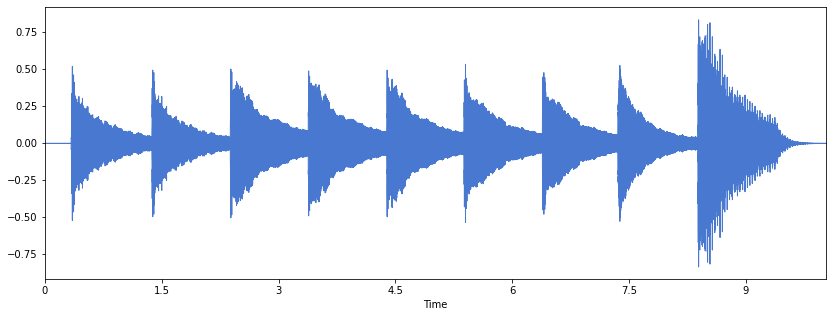

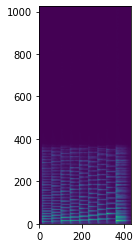

In [5]:
# Audio file
fname = 'Cmajor_piano8khz.wav'

# Load signal
y, sr = librosa.load(fname)

# Compute STFT
Xstft = librosa.stft(y, n_fft=2048, hop_length=512, win_length=None)
X = np.abs(Xstft)

#Visualize the waveform
plt.figure()
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

#Visualize the spectrum
plt.figure()
plt.imshow(X**0.3)
plt.gca().invert_yaxis()


**1. By following the technique that we used in the lecture, derive the MUR algorithm by yourselves.**


Since the MUR algorithm starts with the min problem:

$min_{W∈Rn×k,H∈Rk×m}∥V−WH∥2F s.t. W,H≥0$

Then:

$Tr((V−WH)T(V−WH))[∥X∥2=Tr(XTX)]$

$Tr((VT−HTWT)(V−WH))=Tr(VTV−VTWH−HTWTV+HTWWWH)$

using $Tr(A+B)=Tr(A)+Tr(B)$ we get,

$Tr(VTV)−Tr(VTWH)−Tr(HTWTV)+Tr(HTWTWH)(1)$

The non-negative matrix factorization problem is non-convex in W and H but it is convex in only W or only H. To optimize the above problem, we use a block coordinate descent scheme where we optimize with respect to W first while keeping H fixed and then vice versa.

$W←W−ηW⋅∇Wf(W,H)$
$H←H−ηH⋅∇Hf(W,H)$

Thus to solve the given problem, we need the derivatives of Eq. 1 with respect to W and H. Since the terms in the equation are in trace form, it is simpler to get the derivatives using a few linear algebra rules.

The derivative of each term with respect to $W$,

$∇WTr(VTV)=0$
$∇WTr(VTWH)=∇WTr(HVTW)=(HVT)T=VHT[∇XTr(AX)=AT]$
$∇WTr(HTWTV)=∇WTr(VHTWT)=VHT[∇XTr(XTA)=A]$
$∇WTr(HTWTWH)=∇WTr(WHHTWT)=W((HHT)T+HHT)=2WHHT[∇XTr(XAXT)=X(A+AT)]$

The derivatives with respect to H can computed similarly. Thus,

$∇Wf(W,H)=−2VHT+2WHHT$
$∇Hf(W,H)=−2WTV+2WTWH$

Using the above derivatives,
$W←W+ηW⋅(VHT−WHHT)$
$H←H+ηH⋅(WTV−WTWH)$

The constant 2 can be adjusted in the learning rate and thus can be ignored for now. Traditionally in gradient descent, the learning rates are positive but since the subtraction of terms in the update rules can lead to negative elements, Lee and Seung in the above mentioned paper, proposed to use adaptive learning rates to avoid subtraction and thus the production of negative elements. The learning rates are defined in such a way that there is no subtraction in the update rules. Thus if we set $ηW=WWHHT$ and $ηH=HWTWH$, we arrive at the given update rules.

Another way to avoid subtraction and get the multiplicative update rule is to use the form,

$θ←θ⋅∇−θf(θ)∇+θf(θ)$

where $∇−θf(θ) and ∇+θf(θ)$ are the negative terms and the positive terms, respectively, of the gradient ∇θf(θ).

Using the above mentioned formula and the derivatives produced earlier, we get the following update rule,

$W←W⋅(VHT)(WHHT)$
$H←H⋅(WTV)(WTWH)$

**2. Fill in the template provided in the notebook which will require you to implement the MUR update rules.**

In [6]:
def plot_WH_X(W, H, V, fig, hfig=False):
    F, K = W.shape
    T = H.shape[1]

    ax = fig.add_gridspec(K+2+F, K+2+T)

    figW = fig.add_subplot(ax[K+1:,0:K])
    figW.pcolormesh(W)
    figW.axis('off')
    figW.set_title('W')

    figH = fig.add_subplot(ax[0:K,K+1:])
    figH.pcolormesh(H)
    figH.axis('off')
    figH.set_title('H')

    figX = fig.add_subplot(ax[K+1:,K+1:])
    figX.pcolormesh(V)
    figX.axis('off')
    figX.set_title('V = WH')
    
    plt.draw()
    if hfig:
        hfig.update(fig)
    sleep(0.1)

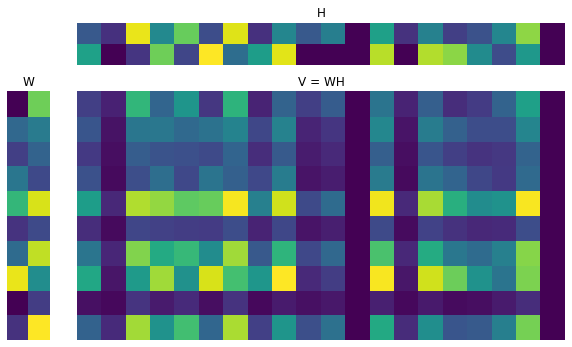

In [19]:
# Create initial W and H

#F,T = X.shape
F = 10
T = 20
K = 2

Wreal = 5*np.random.rand(F,K); Wreal[Wreal < 0.6] = 0.0001
Hreal = 5*np.random.rand(K,T); Hreal[Hreal < 0.6] = 0.0001

V = np.matmul(Wreal,Hreal)

fig = plt.figure(figsize=(10,10*(K+2+F)/(K+2+T)))
plot_WH_X(Wreal, Hreal, V, fig)

In [9]:
# Implement MUR for NMF with beta-divergence 
def MUR(V, K, beta=1, verbose=False):
    F,T = V.shape
    
    W = 5*np.random.rand(F,K); W[W == 0] = 0.0001
    H = 5*np.random.rand(K,T); H[H == 0] = 0.0001
    
    MaxIter = 10
    err = np.zeros(MaxIter)

    if verbose:
        fig = plt.figure(figsize=(10,10*(K+2+F)/(K+2+T)))
        hfig = display(fig, display_id=True)
        plot_WH_X(Wreal, Hreal, V, fig, hfig)
    
    for i in range(MaxIter):
        
        # Updating W
        Vhat = np.matmul(W,H)
        W = W * ( np.matmul((V * (Vhat**(beta-2))),H.transpose()) / np.matmul(Vhat**(beta-1),H.transpose()) )
        if verbose:
            plot_WH_X(W, H, Vhat, fig, hfig)
        
        err[i] = (V*np.log(V) - V*np.log(Vhat) - V + Vhat).sum()
        
        # Updating H
        Vhat = np.matmul(W,H)
        H = H * ( np.matmul(W.transpose(),(V * (Vhat**(beta-2)))) / np.matmul(W.transpose(),Vhat**(beta-1)) )
        if verbose:
            plot_WH_X(W, H, Vhat, fig, hfig)
    return err


In [16]:
type(V)
V.shape

(10, 20)

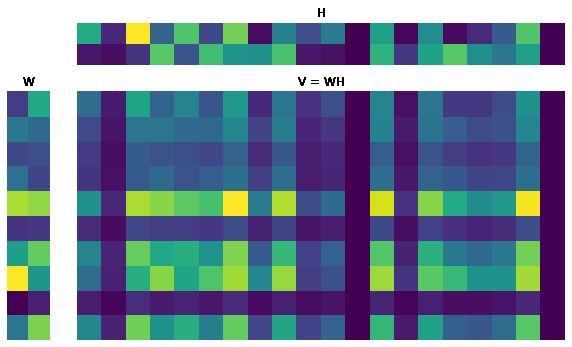

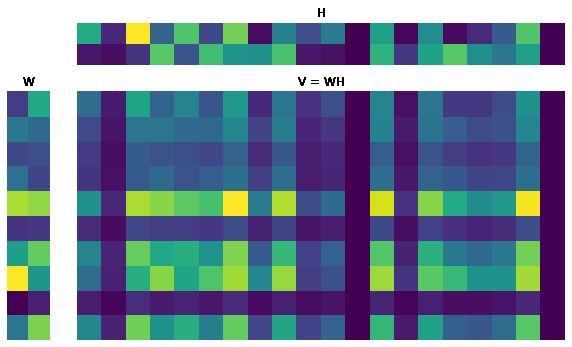

In [23]:
# Test
err = MUR(V,K,0.5,verbose=True)

In [17]:
type(X)
X.shape

(1025, 432)

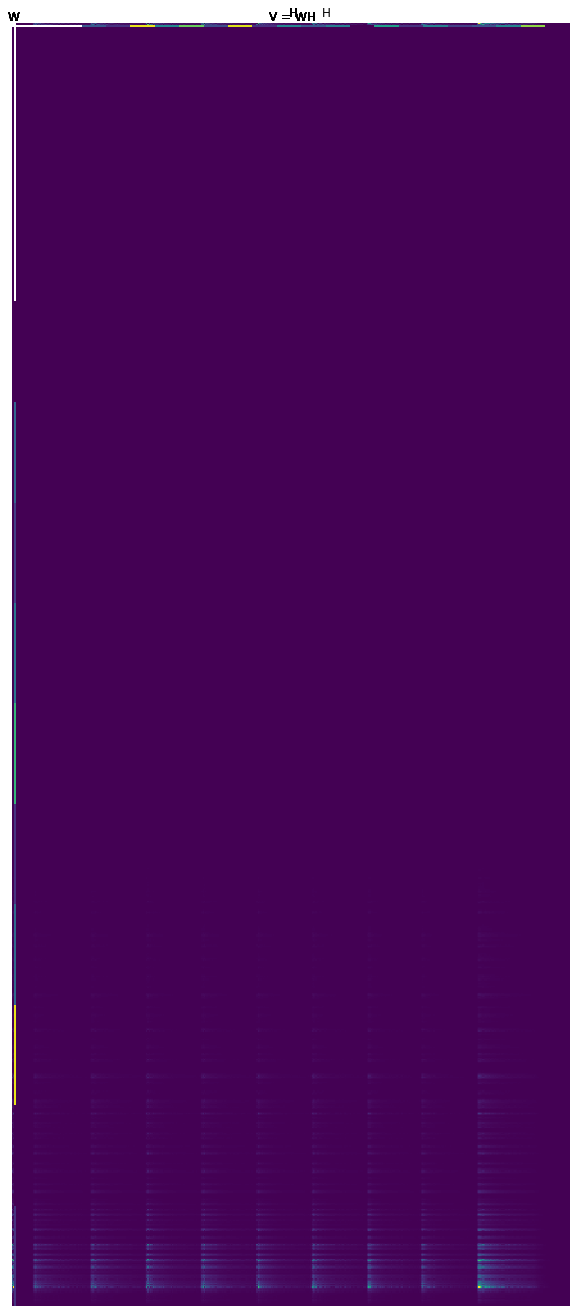

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in matmul
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


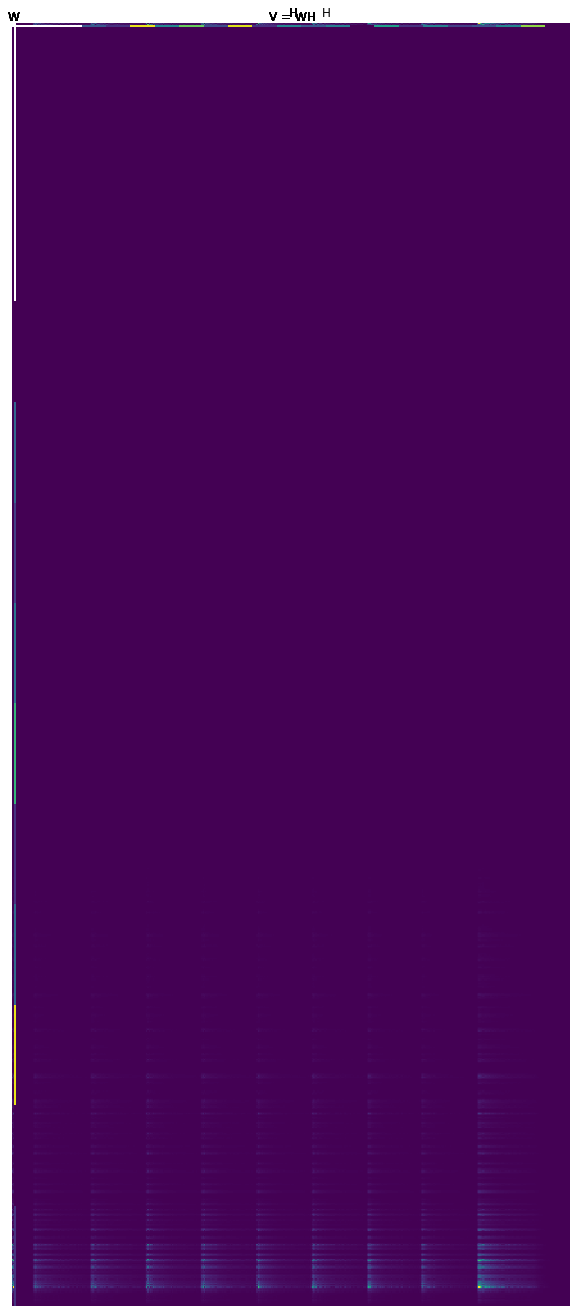

In [24]:
# Application of MUR in the audio signal
err = MUR(X,K,0.5,verbose=True)
plt.semilogy(err);

**3. Experiment with the algorithm parameters, such as β, number of columns in W, STFT window size, STFT hop size etc. What do you observe?**

Changing $\beta=1$

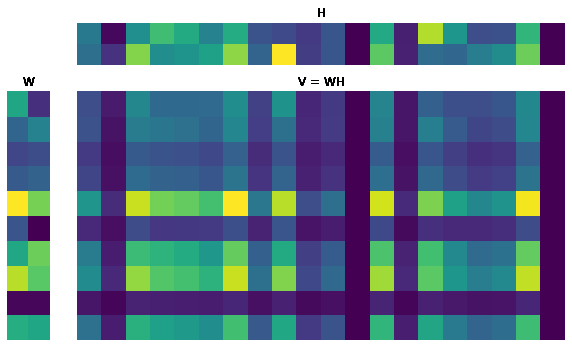

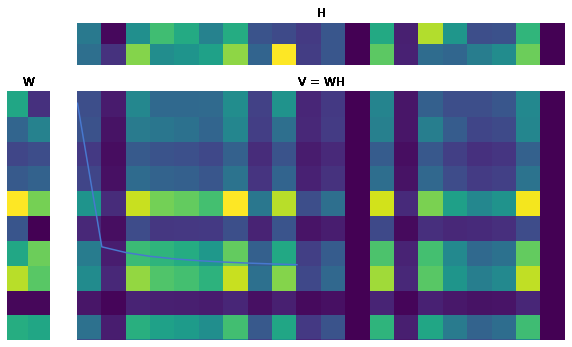

In [31]:
# Application of MUR in the audio signal
err = MUR(V,K,1,verbose=True)
plt.semilogy(err);

Changing $\beta=5$

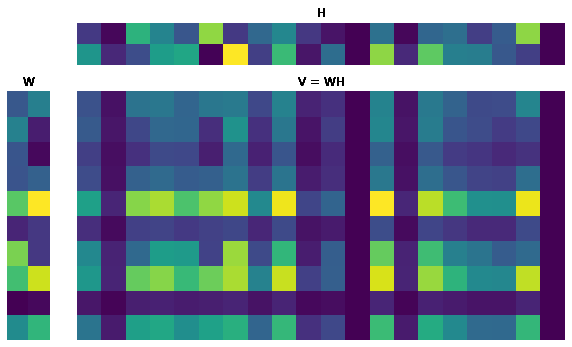

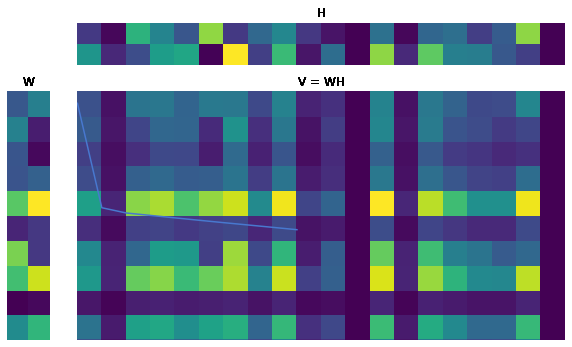

In [32]:
# Application of MUR in the audio signal
err = MUR(V,K,5,verbose=True)
plt.semilogy(err);

Changing $K=3$

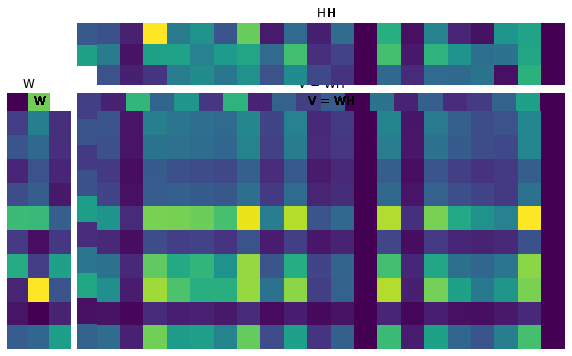

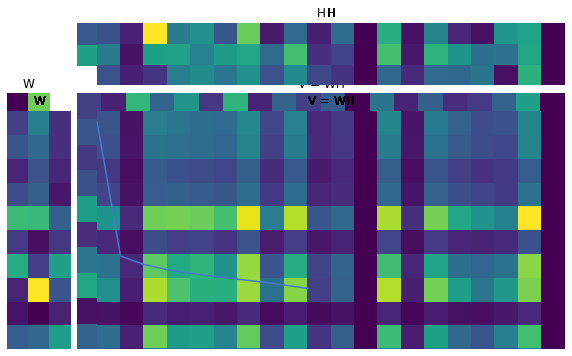

In [36]:
# Application of MUR in the audio signal
err = MUR(V,3,.5,verbose=True)
plt.semilogy(err)

We can see that the algorithm converges very fast and perfom the musical transcription in good way with all the fundamental frecuencies in matrix W. If we change the $\beta$ we will obtain a faster convergence rate of the algorithm wich means a that the musical transcription will be developed in low time. Since we are performing a decreasing optimal method to find the minima, we will go down in the algorithm faster or slower by changing this parameter. Noe considering the changes in the number of columns W, we will see that we are increasing the number of funfamental frecuencies, this means that we have to choose carefully depending in the number of notes that we want to decompose. At the end, a bigger number of columns will result in a better understanding of how many notes are perdorming in the musical audio.